# Keras with the PyTorch Backend: MNIST CNN Tutorial

This walkthrough prepares you to build and train neural networks with Keras while running on the PyTorch backend. We'll mirror the tooling students will use on quizzes and homework: the Sequential API, common layers, compilation settings, callbacks, evaluation, predictions, and saving models.

 # Video walkthrough:
 https://northwestern.zoom.us/rec/share/iNJ--cLUYj22vPyCpKEVZalP11wzQzJ63g8RbXLjYAp-P5M9919yG-907RDaA8sT.0DN2MWY7gmjwIoBg

## Learning goals

- Configure Keras to run with the PyTorch backend
- Load and preprocess image data
- Build convolutional models with the Sequential API
- Compile models with the right losses, optimizers, and metrics
- Train with validation data and interpret history plots
- Evaluate, predict, and persist models for later reuse

## Executive summary

- Connect Keras 3 to the PyTorch runtime so you can reuse PyTorch tooling while staying in the high-level Keras API.
- Walk through an end-to-end MNIST pipeline: inspect raw digits, normalize the data, and add the channel dimension PyTorch convolutions expect.
- Assemble and train a compact Sequential CNN while monitoring the metrics that appear on quizzes (loss, accuracy, early stopping).
- Capture best-performing weights with callbacks, evaluate on held-out data, and generate sample predictions to sanity-check the model.
- Stretch toward project work with a Functional API variant and guided experiments in the sandbox cells provided at the end.


## 0. Prerequisites

Make sure your environment has the PyTorch backend enabled for Keras 3. If you are working locally and `torch` is missing, install the `[torch]` extra for Keras (replace the index URL with the right one for your platform):

```bash
pip install 'keras[torch]' torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
```

After installation, start a **fresh kernel** and run the snippet below once to switch and confirm the backend before importing heavy submodules (like `keras.layers`):

```python
import keras
keras.config.set_backend("torch")
print("Using backend:", keras.config.backend())
```

If you have access to a GPU, install the matching CUDA wheel from [pytorch.org/get-started](https://pytorch.org/get-started/locally/) and the backend call above will automatically pick it up.


In [2]:
import os
os.environ['KERAS_BACKEND']='torch'

import keras
from keras import ops

# Switch to the PyTorch backend if the environment is still on TensorFlow.
if keras.config.backend() != 'torch':
    keras.config.set_backend('torch')

import torch
print('Keras version:', keras.__version__)
print('Selected backend:', keras.config.backend())
print('PyTorch version:', torch.__version__)

Keras version: 3.11.3
Selected backend: torch
PyTorch version: 2.8.0


#### Why this matters

Keras 3 can talk to multiple numerical runtimes. Explicitly switching to the PyTorch backend up front guarantees the rest of the notebook exercises the same kernels, memory formats, and GPU support that students use in other PyTorch-heavy assignments. If you forget this step, you risk silently training with TensorFlow and getting different performance characteristics or API behavior.


> **Tip:** If the backend still prints `tensorflow`, restart the notebook runtime after installing PyTorch and rerun the config cell. You can call `keras.config.list_backends()` to view the valid options and confirm that `torch` is available.


## 1. Load and inspect the MNIST dataset

We'll classify handwritten digits. Keras ships the dataset so we do not need external downloads. Each image is a 28×28 grayscale grid, and the labels range from 0–9. Expect 60,000 training samples and 10,000 test samples—perfect for quick iteration.


In [3]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training set shape:', x_train.shape, y_train.shape)
print('Test set shape:', x_test.shape, y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28) (60000,)
Test set shape: (10000, 28, 28) (10000,)


#### Why this matters

Inspecting the raw shapes before any preprocessing catches issues such as truncated downloads or swapped axes. MNIST’s balanced class distribution also makes it the perfect sandbox: success criteria are clear, and students can translate the workflow to harder datasets later.


### Normalize and add a channel dimension

PyTorch convolutions expect a channel axis. We scale pixel intensities into [0, 1] floats and append a singleton channel dimension.

In [4]:
# Convert uint8 images to float32 [0, 1]
x_train = (x_train.astype('float32') / 255.0)[..., None]
x_test = (x_test.astype('float32') / 255.0)[..., None]

print('Updated shape:', x_train.shape, x_test.shape)

Updated shape: (60000, 28, 28, 1) (10000, 28, 28, 1)


#### Why this matters

Normalizing pixel values stabilizes gradients so optimizers converge faster, and adding the channel dimension aligns the data with PyTorch’s `NCHW` expectation. Skipping either step leads to training instability or shape errors downstream.


### Peek at a few digits

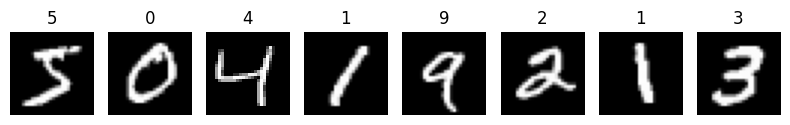

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(x_train[i, ..., 0], cmap='gray')
    plt.axis('off')
    plt.title(int(y_train[i]))
plt.tight_layout()

#### Why this matters

Visual checks expose label mismatches, corrupted samples, or preprocessing bugs long before you commit to a full training run. Investing ten seconds here saves minutes of debugging later.


#### Instructor checklist

- Confirm the plotted digits match the labels printed on top of each subplot.
- Watch for inverted colors or noisy pixels—signs that normalization or reshaping went wrong.
- Encourage students to swap `i` in the loop to explore more samples.


## 2. Build a Sequential CNN

We start with a compact convolutional architecture tailored to MNIST. Two convolution–pooling blocks learn local stroke patterns, followed by dropout-regularized dense layers that map features to digit probabilities.


In [6]:
from keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.summary()

/Users/ltan/Documents/STAT 362-0/stat362-1/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Why this matters

Reading the model summary connects abstract architecture diagrams to concrete tensor shapes. Students learn how pooling shrinks spatial dimensions, why dropout reduces overfitting, and how many parameters they are responsible for training.


Key layers you should recognize for quizzes/homework:
- `Conv2D`: learnable filters capturing local patterns
- `MaxPooling2D`: downsample feature maps
- `Dropout`: regularization to fight overfitting
- `Dense` with `softmax`: map to class probabilities

## 3. Compile the model

We use Adam, categorical cross-entropy, and accuracy—exactly the training stack students will rely on. Adjust the learning rate if you see plateaus or diverging loss in later experiments.


In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')],
)

#### Why this matters

Adam with categorical cross-entropy is the baseline trio our assessments expect. Understanding the defaults lets students reason about when to adjust learning rates, swap optimizers, or track additional metrics for research questions.


## 4. Prepare labels and callbacks

Convert labels to one-hot vectors for the softmax output layer and configure callbacks that align with homework expectations.


In [8]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

y_train_categorical = to_categorical(y_train, num_classes=10)
y_test_categorical = to_categorical(y_test, num_classes=10)

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('mnist_cnn_torch.keras', save_best_only=True),
]


#### Why this matters

One-hot labels unlock the softmax output, and callbacks enforce reproducibility. Early stopping prevents wasted epochs once validation loss plateaus, while checkpointing preserves the best weights for reports or deployment.


`EarlyStopping` mirrors what we encourage in assignments: stop once validation loss stops improving for a few epochs. `ModelCheckpoint` persists your best weights automatically, giving you a fallback if later epochs overfit.


## 5. Train with validation data

Keep an eye on the history dictionary—it will show up on quizzes. With the settings below, you should see ~99% validation accuracy in under a minute on modern hardware.


In [9]:
history = model.fit(
    x_train,
    y_train_categorical,
    epochs=15,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/15
422/422 - 15s - 36ms/step - accuracy: 0.9256 - loss: 0.2591 - val_accuracy: 0.9790 - val_loss: 0.0760
Epoch 2/15
422/422 - 15s - 35ms/step - accuracy: 0.9752 - loss: 0.0839 - val_accuracy: 0.9843 - val_loss: 0.0533
Epoch 3/15
422/422 - 14s - 34ms/step - accuracy: 0.9814 - loss: 0.0608 - val_accuracy: 0.9882 - val_loss: 0.0436
Epoch 4/15
422/422 - 14s - 34ms/step - accuracy: 0.9846 - loss: 0.0500 - val_accuracy: 0.9903 - val_loss: 0.0368
Epoch 5/15
422/422 - 14s - 34ms/step - accuracy: 0.9878 - loss: 0.0401 - val_accuracy: 0.9893 - val_loss: 0.0364
Epoch 6/15
422/422 - 15s - 35ms/step - accuracy: 0.9880 - loss: 0.0360 - val_accuracy: 0.9910 - val_loss: 0.0331
Epoch 7/15
422/422 - 14s - 34ms/step - accuracy: 0.9905 - loss: 0.0300 - val_accuracy: 0.9912 - val_loss: 0.0351
Epoch 8/15
422/422 - 15s - 34ms/step - accuracy: 0.9916 - loss: 0.0263 - val_accuracy: 0.9913 - val_loss: 0.0313
Epoch 9/15
422/422 - 14s - 34ms/step - accuracy: 0.9923 - loss: 0.0237 - val_accuracy: 0.9910 - 

#### Why this matters

The training loop is where theory meets hardware constraints. By logging history on every epoch, students can tie optimizer choices to observable behavior—critical when justifying design decisions on homework and exams.


### Interpreting the training logs

- Look for validation loss to flatten or rise slightly—that is when `EarlyStopping` will trigger.
- If training accuracy climbs while validation accuracy stagnates, consider more dropout or data augmentation.
- Large gaps between training and validation loss often signal overfitting.


### Plot the learning curves

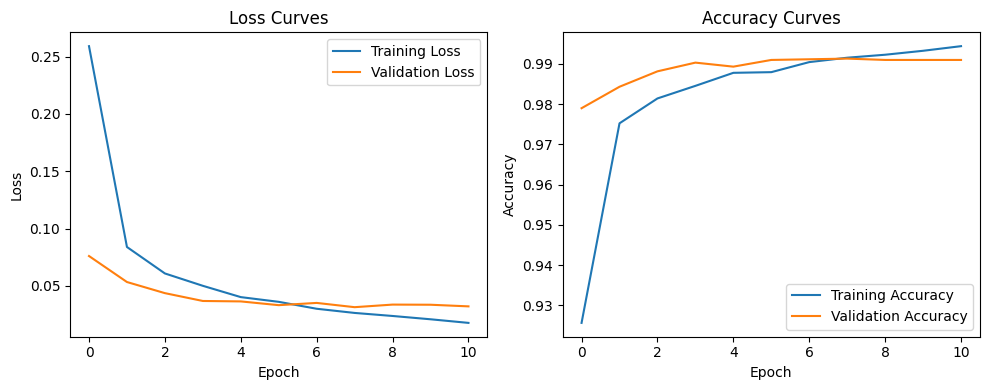

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()

### Reading the curves

- Balanced, downward loss curves for both splits indicate the optimizer is behaving.
- Validation accuracy should track training accuracy; a large gap suggests the model is memorizing.
- Screenshot these plots for lab reports—they double as evidence of convergence.


#### Why this matters

Turning raw history values into visual diagnostics helps students develop intuition. Patterns like widening loss gaps or noisy accuracy swings become immediate cues to tweak architecture or regularization.


## 6. Evaluate on the test set

Hold back the official test split until now so you get an unbiased estimate of generalization.


In [11]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_categorical, verbose=0)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

Test loss: 0.0300
Test accuracy: 0.9902


#### Why this matters

Holding the test split until the end preserves an honest estimate of generalization. Reporting both loss and accuracy reinforces that metrics can tell complementary stories.


## 7. Make predictions

Grab a handful of samples and inspect both the predicted labels and the raw probability vectors. This quick sanity check catches label shuffling mistakes early.


In [12]:
probabilities = model.predict(x_test[:5])
predicted_digits = np.argmax(probabilities, axis=1)

for i, (pred, target) in enumerate(zip(predicted_digits, y_test[:5])):
    print(f'Sample {i}: predicted {pred}, target {target}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
Sample 0: predicted 7, target 7
Sample 1: predicted 2, target 2
Sample 2: predicted 1, target 1
Sample 3: predicted 0, target 0
Sample 4: predicted 4, target 4


#### Why this matters

Checking a handful of predictions humanizes the model’s behavior. Students practice spotting when high-confidence errors stem from ambiguous data, preprocessing mistakes, or insufficient model capacity.


### Sanity checks

- Confirm the predicted digit matches the target for most samples.
- Investigate any confident misclassifications—were the inputs ambiguous or noisy?
- Consider displaying `probabilities[i]` to discuss softmax confidence calibration.


## 8. Reload the best model from disk

`ModelCheckpoint` saved a `.keras` file. Reload it to demonstrate how we recover the best-performing weights for deployment or further evaluation.


In [13]:
best_model = keras.models.load_model('mnist_cnn_torch.keras')
reloaded_loss, reloaded_accuracy = best_model.evaluate(x_test, y_test_categorical, verbose=0)
print(f'Reloaded model accuracy: {reloaded_accuracy:.4f}')

Reloaded model accuracy: 0.9902


#### Why this matters

Being able to reload and evaluate saved weights is essential for collaboration, grading, and deployment. It proves the training artifacts are portable across sessions and machines.


## 9. Optional: Functional API example

For more complex homeworks, you may need skip connections or parallel branches. Here is the same classifier built with the Functional API so you can practice moving between paradigms.


In [14]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)
functional_model = keras.Model(inputs, outputs, name='mnist_functional')
functional_model.summary()

Model: "mnist_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Why this matters

The Functional API is the bridge to advanced architectures. Understanding it now means students can later implement residual blocks, attention mechanisms, or multi-branch models without switching frameworks.


Compile, train, and evaluate this model with the same pipeline as practice. The Functional API becomes essential for architectures like residual blocks or multi-input models—skills you'll tap during the final project.


## 10. Your turn

Use the empty cells below to experiment. Tie your notes back to the lab rubric by capturing metrics, plots, and a 2–3 sentence reflection for each tweak you try.


### Task A: Try a different optimizer (e.g., RMSprop) and compare the learning curves.

Focus on how quickly each optimizer reaches 98% validation accuracy and whether the loss curves stay smooth.


### Task B: Add Batch Normalization after each convolution and observe its impact.

Record convergence speed.


### Task C: Build a deeper network (3+ convolutional blocks) and monitor for overfitting.

Track validation loss and test accuracy; try pairing additional depth with stronger regularization.
